In [2]:
%cd /mnt/c/Users/Habush/PycharmProjects/bnn_bg
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.train_utils import *
from utils.losses import *
from utils.data_utils import *
from core.sgmcmc import *
from core.bnn_model import *
plt.style.use("ggplot")
%load_ext autoreload

/mnt/c/Users/Habush/PycharmProjects/bnn_bg


2024-01-26 15:54:44.082472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [34]:
data_npz = np.load("./data/synth_reg_data.npz")
x_ = jnp.asarray(data_npz["x_"])
y_ = jnp.asarray(data_npz["y_"])
f_ = jnp.asarray(data_npz["f_"])
x = jnp.asarray(data_npz["x"])
y = jnp.asarray(data_npz["y"])
f = jnp.asarray(data_npz["f"])

data_info = {"y_scale": 1.}

In [3]:
def inv_softplus(x):
    return jnp.log(jnp.exp(x) - 1)

# Noise in the data
noise_std = 0.02
invsp_noise_std = inv_softplus(noise_std)

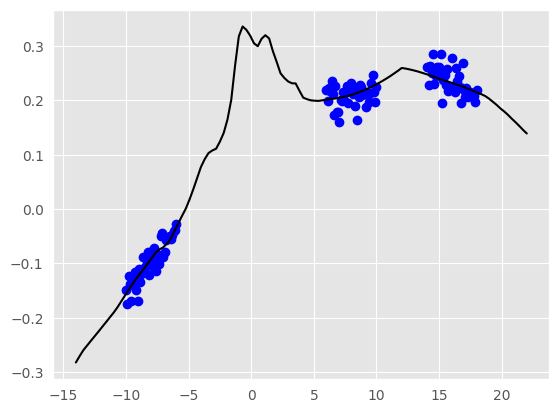

In [4]:
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")

### BNN Model

In [14]:
# Define the model
def make_model(layer_dims, invsp_noise_std):
    def forward(batch, is_training):
        x, _ = batch
        x = hk.Flatten()(x)
        for layer_dim in layer_dims:
            x = hk.Linear(layer_dim)(x)
            x = jax.nn.relu(x)
        x = hk.Linear(1)(x)
        x = jnp.concatenate([x, jnp.ones_like(x) * invsp_noise_std], -1)
        return x
    return forward

net_fn = make_model(layer_dims=[100, 100, 100], invsp_noise_std=invsp_noise_std)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init

In [15]:
def resample_params(seed, params, std=0.005):
    key = jax.random.PRNGKey(seed)
    num_leaves = len(jax.tree_util.tree_leaves(params))
    normal_keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(params)
    normal_keys = jax.tree_util.tree_unflatten(treedef, normal_keys)
    params = jax.tree_util.tree_map(lambda p, k: jax.random.normal(k, p.shape) * std,
                               params, normal_keys)
    return params

In [16]:
param_seed = 0
params, net_state = net_init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params)

In [52]:
from utils.data_utils import Task
train_set = (f, y)
test_set = (f_, y_)

log_prior_fn = make_gaussian_log_prior(1., 1.)
log_likelihood_fn =  losses.make_gaussian_likelihood(1.)
_, predict_fn, ensemble_fn, metrics_fn, tabulate_metrics = get_task_specific_fns(Task.REGRESSION, {"y_scale": 1.})

### SGLD

In [55]:
%autoreload
import core.sgmcmc as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
from utils import losses
lr_schedule = nn_util.make_cyclical_cosine_lr_schedule_with_const_burnin(3.e-8, 3.e-8, 1)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, 0)

In [56]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [59]:
num_iterations = 10000
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 1000
opt_state = optimizer.init(params)
for iteration in tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    if iteration % save_freq == 0:
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 539.52it/s]


Number of sampled models: 10
nll: 4.663439750671387
mse: 0.00612527783960104
rmse: 0.07781638950109482


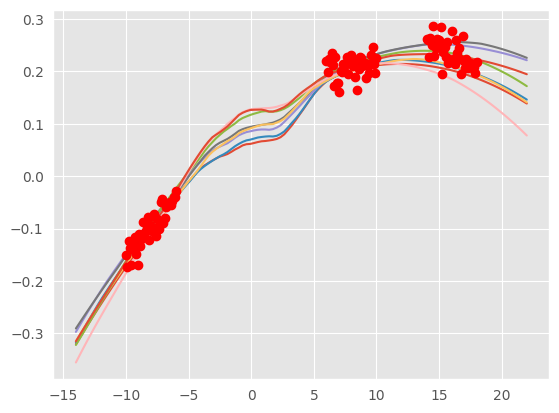

In [60]:
print(f"Number of sampled models: {len(all_test_preds)}")
metrics = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[:,0])
    for k in metrics:
        metrics[k].append(metrics_fn[k](pred, y_))

for k in metrics:
    print(f"{k}: {np.mean(metrics[k])}")

plt.plot(x, y, "ro")
plt.show()

### SGHMC

In [27]:
lr = 1.e-8
mom = 0.95
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, lr, 1)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0)

In [29]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [30]:
num_iters = 10000
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 1000

for iteration in tqdm(range(num_iters)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    if iteration % save_freq == 0:
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(np.asarray(test_predictions))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1023.78it/s]


Number of sampled models: 10
nll: 2.201995849609375
mse: 0.004156102892011404
rmse: 0.0638299435377121


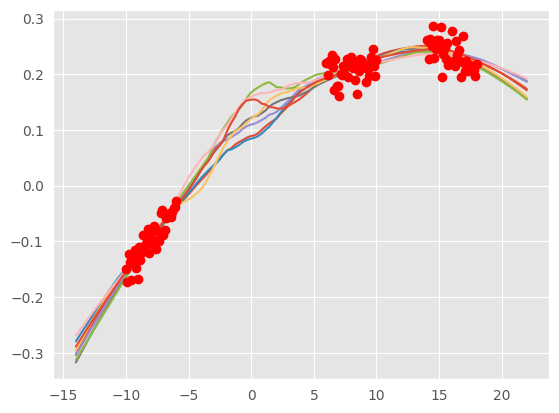

In [37]:
print(f"Number of sampled models: {len(all_test_preds)}")
metrics = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[:,0])
    for k in metrics:
        metrics[k].append(metrics_fn[k](pred, y_))

for k in metrics:
    print(f"{k}: {np.mean(metrics[k])}")

plt.plot(x, y, "ro")
plt.show()

### SGHMC with Cyclical  LR

In [38]:
%autoreload
import core.sgmcmc as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
from utils import losses

lr = 3.e-8
mom = 0.95
burnin_len = 1000
cycle_len = 1000
lr_schedule = nn_util.make_cyclical_cosine_lr_schedule_with_const_burnin(
    lr, burnin_len, cycle_len
)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0)

In [39]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [40]:
num_iterations = 10000
all_test_preds = []
key = jax.random.PRNGKey(0)
lrs = []

for iteration in tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    
    lr = lr_schedule(opt_state.count)
    lrs.append(lr)
    if iteration > burnin_len and (iteration - burnin_len + 1) % cycle_len == 0:
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 260.17it/s]


Number of sampled models: 9
nll: 16.257448196411133
mse: 0.015400580130517483
rmse: 0.11319951713085175


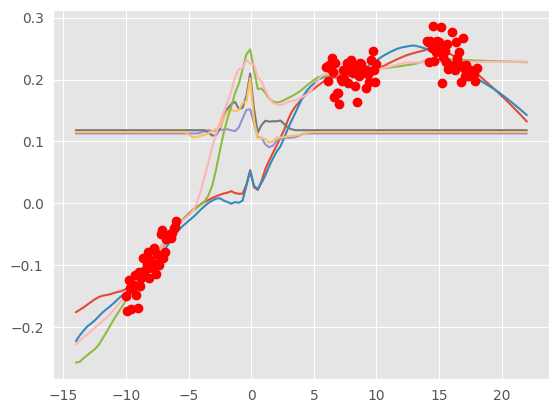

In [41]:
print(f"Number of sampled models: {len(all_test_preds)}")
metrics = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[:,0])
    for k in metrics:
        metrics[k].append(metrics_fn[k](pred, y_))

for k in metrics:
    print(f"{k}: {np.mean(metrics[k])}")

plt.plot(x, y, "ro")
plt.show()

### SGHMC with PreConditioner

In [42]:
lr = 3e-8
mom = 0.95
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, lr, 1)
preconditioner = get_rmsprop_preconditioner()
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0,
                                        preconditioner=preconditioner)

In [43]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [44]:
num_iterations = 10000
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 1000
lrs = []

for iteration in tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    lrs.append(lr_schedule(opt_state.count))
    if iteration % save_freq == 0:
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(np.asarray(test_predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 243.81it/s]


Number of sampled models: 10
nll: 23.701229095458984
mse: 0.02135566622018814
rmse: 0.1450127810239792


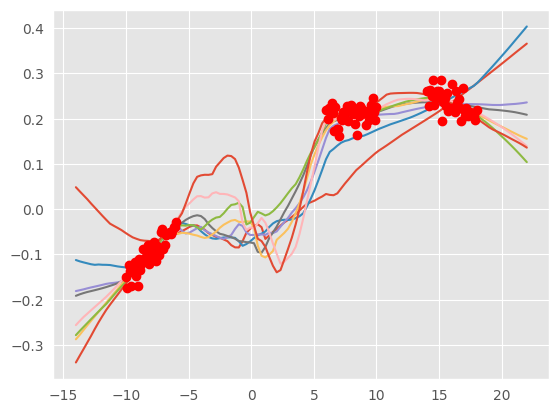

In [46]:
print(f"Number of sampled models: {len(all_test_preds)}")
metrics = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[:,0])
    for k in metrics:
        metrics[k].append(metrics_fn[k](pred, y_))

for k in metrics:
    print(f"{k}: {np.mean(metrics[k])}")

plt.plot(x, y, "ro")
plt.show()

## SGHMC with PreConditioner with Cyclical  LR

In [61]:
lr = 1.e-6
mom = 0.95
burnin_len = 1000
cycle_len = 1000

lr_schedule = nn_util.make_cyclical_cosine_lr_schedule_with_const_burnin(lr, burnin_len, cycle_len)
preconditioner = sgmcmc.get_rmsprop_preconditioner()
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, preconditioner=preconditioner, seed=0)

In [62]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [63]:
num_iterations = 10000
all_test_preds = []
key = jax.random.PRNGKey(0)
lrs = []


for iteration in tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    
    lr = lr_schedule(opt_state.count)
    lrs.append(lr)
    if iteration > burnin_len and (iteration - burnin_len + 1) % cycle_len == 0:
#         print("lr:", lr)
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 250.80it/s]


Number of sampled models: 9
nll: 5717.2255859375
mse: 4.576221466064453
rmse: 2.034799814224243


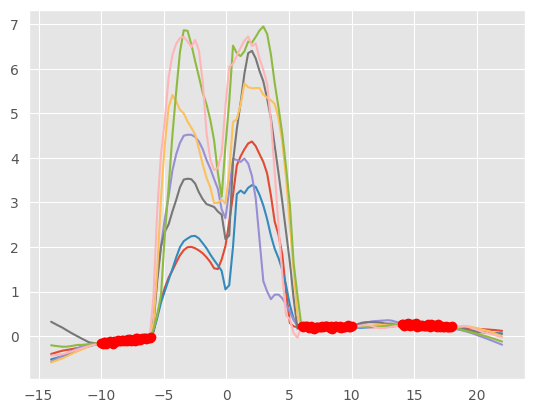

In [64]:
print(f"Number of sampled models: {len(all_test_preds)}")
metrics = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[:,0])
    for k in metrics:
        metrics[k].append(metrics_fn[k](pred, y_))

for k in metrics:
    print(f"{k}: {np.mean(metrics[k])}")

plt.plot(x, y, "ro")
plt.show()

## Mixed BNN

In [124]:
def resample_params(key, params, std=0.005):
    num_leaves = len(jax.tree_util.tree_leaves(params))
    normal_keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(params)
    normal_keys = jax.tree_util.tree_unflatten(treedef, normal_keys)
    params = jax.tree_util.tree_map(lambda p, k: jax.random.normal(k, p.shape) * std,
                               params, normal_keys)
    return params

In [397]:
%autoreload
from s3.helper_functions import synthetic_data, spike_slab_params
from sklearn.model_selection import train_test_split
n = 500

p = 1000
s0 = 10
seed = 5
synth_data = synthetic_data(seed, n, p, s0, random_index=False)

params = spike_slab_params(n, p, type="linear")
tau0, tau1 = params["tau0"], params["tau1"]
# tau0, tau1 = 1e-2, 1.0
a0, b0 = params["a0"], params["b0"]
q = params["q"]
print(f"params: {params}")
J = jnp.zeros((p, p))
eta, mu = 1.0, 1.0

x, y, true_beta, true_beta_idx = synth_data["X"], synth_data["y"], synth_data["true_beta"], synth_data["true_beta_idx"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

train_set = (x_train, y_train)
test_set = (x_test, y_test)
print(f"true beta idx: {true_beta_idx}")

params: {'q': 0.007, 'tau0': 0.044721359549995794, 'tau1': 1.0, 'a0': 1.0, 'b0': 1.0}
true beta idx: [0 1 2 3 4 5 6 7 8 9]


In [415]:
# Define the model
from typing import Sequence
class DropoutLayer(hk.Module):
    def __init__(self, input_size, init_fn=None):
        super().__init__("dropout")
        self.input_size = input_size
        self.init_fn = init_fn

    def __call__(self, x):
        if self.init_fn is None:
            stddev = 1. / np.sqrt(self.input_size)
            self.init_fn = hk.initializers.TruncatedNormal(stddev=stddev)
        w = hk.get_parameter("w", [self.input_size], jnp.float32, init=self.init_fn)
        return w*x


def make_model(layer_dims: Sequence[int], invsp_noise_std: float) -> object:
    def forward(batch, is_training):
        x, _ = batch
        # x = hk.Flatten()(x)
        x = DropoutLayer(x.shape[-1])(x)
        for i, layer_dim in enumerate(layer_dims):
            x = hk.Linear(layer_dim, name=f"linear_{i}")(x)
            x = jax.nn.relu(x)
        x = hk.Linear(1)(x)
        x = jnp.concatenate([x, jnp.ones_like(x) * invsp_noise_std], -1)
        return x
    return forward

In [433]:
%autoreload
import core.sgmcmc as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
from utils import losses as losses
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

weight_decay, temp = 1.0, 1.0
prior_scale = 1.0
log_prior_fn = losses.make_spike_slap_log_prior(tau0, tau1, 
                                                     weight_decay, temp)
log_likelihood_fn = losses.make_gaussian_likelihood(temp)

bin_log_prior_fn = losses.make_bin_log_prior(J, eta, mu)
bin_log_likelihood_fn = losses.make_bin_log_likelihood(tau0, tau1, q,
                                                       weight_decay, temp)

predict_fn = train_utils.get_regression_gaussian_predictions

lr = 1e-3
bin_lr = 0.2
mom = 0.95
num_iters = 2000
burnin_len = 1000
cycle_len = 1000
rmsprop_precond = get_rmsprop_preconditioner()
rmsprop_precond_bin = get_rmsprop_preconditioner()
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, 1e-8, burnin_len)
bin_lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(bin_lr, 0.001, burnin_len)
# lr_schedule = optax.constant_schedule(lr)
# bin_lr_schedule = optax.constant_schedule(bin_lr)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=seed, preconditioner=rmsprop_precond)
bin_optimizer = sgmcmc.disc_bin_sgld_gradient_update(bin_lr_schedule, 
                                                     seed, preconditioner=rmsprop_precond)

init_rng = jax.random.PRNGKey(0)
net_fn = make_model(layer_dims=[100, 100], invsp_noise_std=1.0)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
params, net_state = net.init(init_rng, (x_train[0], None), True)
params = resample_params(init_rng, params, std=0.05)
# def tree_fn(p):
#     return tfd.Bernoulli(probs=jnp.ones_like(p)*q).sample(seed=init_rng)*1.0
# 
# gamma = jax.tree_map(lambda p: tree_fn(p), params)
gamma = tfd.Bernoulli(probs=jnp.ones(p)*q).sample(seed=init_rng)*1.0
# params["dropout"]["w"] = jnp.zeros_like(gamma)
opt_state = optimizer.init(params)
bin_opt_state = bin_optimizer.init(gamma)
sgmcmc_train_epoch_mixed = train_utils.make_sgd_train_epoch_mixed(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer,
    bin_log_likelihood_fn, bin_log_prior_fn, bin_optimizer, num_batches=5)

In [434]:
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 100

param_samples = []
gamma_samples = []
log_prob_avgs = []
bin_log_probs_avgs = []


# iters = range(num_iters)
iters = tqdm(range(num_iters))

for iteration in iters:
    params, gamma, net_state, opt_state, bin_opt_state, logprob_avg, bin_loss_avg, key = sgmcmc_train_epoch_mixed(
        params, gamma, net_state, opt_state, bin_opt_state, 
        train_set, key)
    # if iteration % save_freq == 0:
    #     _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
    #     all_test_preds.append(np.asarray(test_predictions))
    log_prob_avgs.append(logprob_avg)
    bin_log_probs_avgs.append(bin_loss_avg)
    if iteration > burnin_len and iteration % save_freq == 0:
        param_samples.append(params)
        gamma_samples.append(gamma)
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.64it/s]


Text(0.5, 1.0, 'Binary variable')

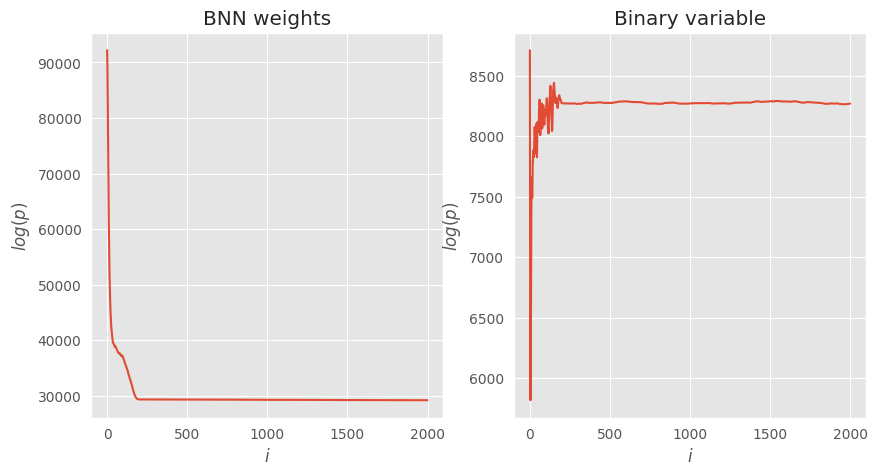

In [435]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(log_prob_avgs)
ax1.set_ylabel("$log(p)$")
ax1.set_xlabel("$i$")
ax1.set_title("BNN weights")
ax2.plot(bin_log_probs_avgs)
ax2.set_ylabel("$log(p)$")
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

Text(0.5, 1.0, 'Binary variable')

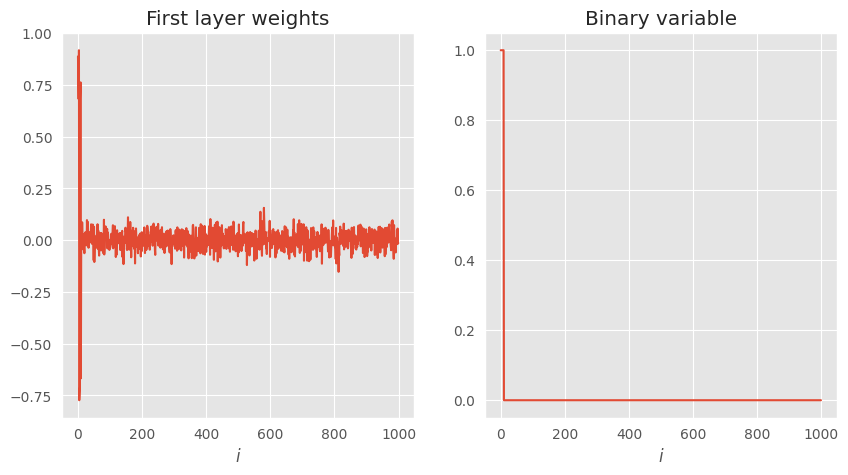

In [436]:
param_samples_st = tree_utils.tree_stack(param_samples)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.plot(np.mean(np.linalg.norm(param_samples_st["linear_0"]["w"], axis=-1), axis=0))
ax1.plot(np.mean(param_samples_st["dropout"]["w"], axis=0))
ax1.set_xlabel("$i$")
ax1.set_title("First layer weights")
ax2.plot(np.mean(gamma_samples, axis=0))
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

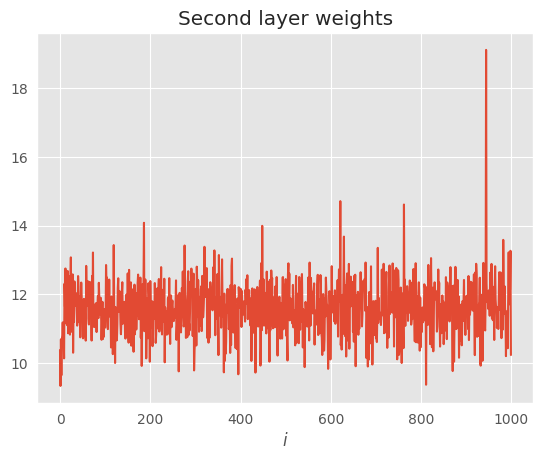

In [437]:
# param_samples_st = tree_utils.tree_stack(param_samples)
plt.plot(np.mean(np.linalg.norm(param_samples_st["linear_0"]["w"], axis=-1), axis=0))
plt.xlabel("$i$")
plt.title("Second layer weights")
plt.show()

In [438]:
%autoreload
from utils import metrics

data_scale = 1.0
metrics_fns = {
    "scaled_nll": metrics.regression_nll,
    "scaled_mse": metrics.mse,
    "scaled_rmse": metrics.rmse,
    "nll": lambda preds, y: metrics.regression_nll(preds, y, data_scale),
    "mse": lambda preds, y: metrics.mse(preds, y, data_scale),
    "rmse": lambda preds, y: metrics.rmse(preds, y, data_scale),
}

print(f"Number of sampled models: {len(all_test_preds)}")
metrics_val = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    for k in metrics_val:
        metrics_val[k].append(metrics_fns[k](pred, y_test))

for k in metrics_val:
    print(f"{k}: {np.mean(metrics_val[k])}")

Number of sampled models: 9
nll: 2.361219582920061
mse: 4.034892707699174
rmse: 2.0086307477672976




### Ribflavin Data

In [469]:
import pandas as pd
seed = 835
data_path = "/mnt/c/Users/Habush/PycharmProjects/bnn_bg/data"
riboflavin = pd.read_csv(f"{data_path}/riboflavin.csv")
riboflavin_y = riboflavin['y'].to_numpy()
riboflavin_x = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()
print(riboflavin.shape)
riboflavin_x_train, riboflavin_x_test, riboflavin_y_train, riboflavin_y_test = train_test_split(riboflavin_x, 
                                                                                                    riboflavin_y, 
                                                                                                    test_size=0.1, 
                                                                                                    random_state=seed)
n, p = riboflavin_x_train.shape
train_set = (riboflavin_x_train, riboflavin_y_train)
test_set = (riboflavin_x_test, riboflavin_y_test)
print(riboflavin_x_train.shape)

(71, 4090)
(63, 4088)


In [470]:
# Define the model
class DropoutLayer(hk.Module):
    def __init__(self, input_size, init_fn=None):
        super().__init__("dropout")
        self.input_size = input_size
        self.init_fn = init_fn

    def __call__(self, x):
        if self.init_fn is None:
            stddev = 1. / np.sqrt(self.input_size)
            self.init_fn = hk.initializers.TruncatedNormal(stddev=stddev)
        w = hk.get_parameter("w", [self.input_size], jnp.float32, init=self.init_fn)
        return x*w


def make_model(layer_dims: Sequence[int], invsp_noise_std: float) -> object:
    def forward(batch, is_training):
        x, _ = batch
        # x = hk.Flatten()(x)
        x = DropoutLayer(x.shape[-1])(x)
        for i, layer_dim in enumerate(layer_dims):
            x = hk.Linear(layer_dim, name=f"linear_{i}")(x)
            x = jax.nn.relu(x)
        x = hk.Linear(1)(x)
        x = jnp.concatenate([x, jnp.ones_like(x) * invsp_noise_std], -1)
        return x
    return forward
net_fn = make_model(layer_dims=[100, 100], invsp_noise_std=0.001)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init

In [471]:
%autoreload
import core.sgmcmc as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
from utils import losses

weight_decay, temp = 1.0, 1.0

log_prior_fn = losses.make_spike_slap_log_prior(tau0, tau1, 
                                                     weight_decay, temp) #TODO test a L2 prior
log_likelihood_fn = losses.make_gaussian_likelihood(temp)

bin_log_prior_fn = losses.make_bin_log_prior(J, eta, mu)
bin_log_likelihood_fn = losses.make_bin_log_likelihood(tau0, tau1, q,
                                                       weight_decay, temp)

predict_fn = train_utils.get_regression_gaussian_predictions

In [484]:
import optax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

n, p = riboflavin_x.shape

params = spike_slab_params(n, p, type="linear")
tau0, tau1 = params["tau0"], params["tau1"]
# tau0, tau1 = 1e-3, 0.1
a0, b0 = params["a0"], params["b0"]
q = params["q"]
print(f"params: {params}")
# q = 0.01
lr = 1e-4
bin_lr = 0.2
mom = 0.95
num_iters = 2000
burnin_len = 1000
cycle_len = 1000
rmsprop_precond = get_rmsprop_preconditioner()
rmsprop_precond_bin = get_rmsprop_preconditioner()
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, 1e-8, num_iters)
bin_lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(bin_lr, 1e-2, num_iters)
# lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(lr, num_iters, cycle_len)
# bin_lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(bin_lr, num_iters, cycle_len)
# lr_schedule = optax.constant_schedule(lr)
# bin_lr_schedule = optax.constant_schedule(bin_lr)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=seed, preconditioner=rmsprop_precond)
bin_optimizer = sgmcmc.disc_bin_sgld_gradient_update(bin_lr_schedule,
                                                     seed, preconditioner=rmsprop_precond)
init_rng = jax.random.PRNGKey(0)

params, net_state = net.init(init_rng, (riboflavin_x_train[0], None), True)
# params = resample_params(init_rng, params, std=0.05)
# first_layer_shape = params["linear_0"]["w"].shape
gamma = tfd.Bernoulli(probs=jnp.ones(p)*q).sample(seed=init_rng)*1.0
# params["dropout"]["w"] = gamma * params["dropout"]["w"]
# params["dropout"]["w"] = jnp.zeros_like(gamma)
opt_state = optimizer.init(params)
bin_opt_state = bin_optimizer.init(gamma)
sgmcmc_train_epoch_mixed = train_utils.make_sgd_train_epoch_mixed(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer,
    bin_log_likelihood_fn, bin_log_prior_fn, bin_optimizer, num_batches=2)

params: {'q': 0.0017123287671232876, 'tau0': 0.11867816581938533, 'tau1': 1.0, 'a0': 1.0, 'b0': 1.0}


In [485]:
all_test_preds = []
key = jax.random.PRNGKey(0)
save_freq = 100

param_samples = []
gamma_samples = []
log_prob_avgs = []
bin_log_probs_avgs = []


# iters = range(num_iters)
iters = tqdm(range(num_iters))

for iteration in iters:
    params, gamma, net_state, opt_state, bin_opt_state, logprob_avg, bin_loss_avg, key = sgmcmc_train_epoch_mixed(
    params, gamma, net_state, opt_state, bin_opt_state, 
    train_set, key)

    log_prob_avgs.append(logprob_avg)
    bin_log_probs_avgs.append(bin_loss_avg)
    # if iteration > burnin_len and (iteration - burnin_len) % cycle_len == 0:
    if iteration > burnin_len and iteration % save_freq == 0:
        param_samples.append(params)
        gamma_samples.append(gamma)
        _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
        all_test_preds.append(onp.asarray(test_predictions))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 177.27it/s]


Text(0.5, 1.0, 'Binary variable')

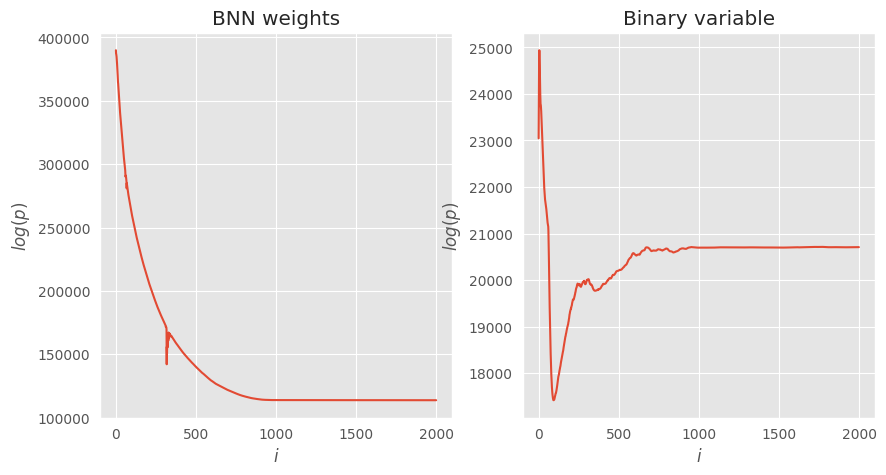

In [486]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(log_prob_avgs)
ax1.set_ylabel("$log(p)$")
ax1.set_xlabel("$i$")
ax1.set_title("BNN weights")
ax2.plot(bin_log_probs_avgs)
ax2.set_ylabel("$log(p)$")
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

Text(0.5, 1.0, 'Binary variable')

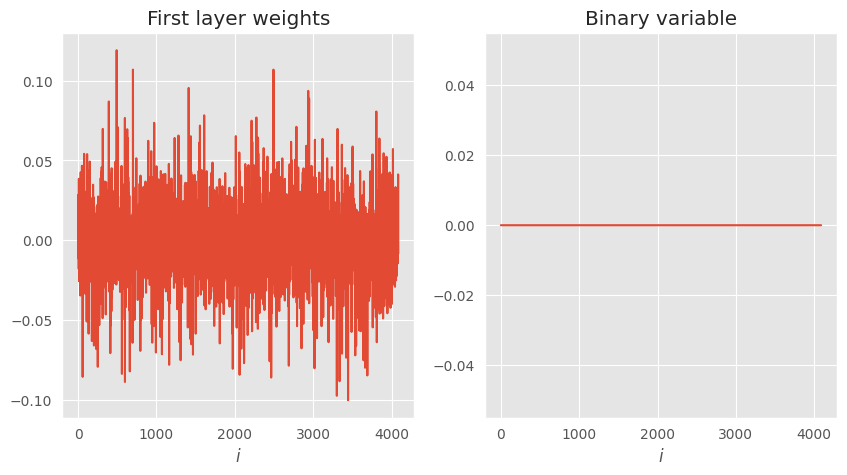

In [487]:
param_samples_st = tree_utils.tree_stack(param_samples)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(np.mean(param_samples_st["dropout"]["w"], axis=0))
ax1.set_xlabel("$i$")
ax1.set_title("First layer weights")
# ax2.plot(np.mean(gamma_samples, axis=0))
ax2.plot(np.mean(gamma_samples, axis=0))
ax2.set_xlabel("$i$")
ax2.set_title("Binary variable")

In [488]:
%autoreload
from utils import metrics

data_scale = 1.0
metrics_fns = {
    "scaled_nll": metrics.regression_nll,
    "scaled_mse": metrics.mse,
    "scaled_rmse": metrics.rmse,
    "nll": lambda preds, y: metrics.regression_nll(preds, y, data_scale),
    "mse": lambda preds, y: metrics.mse(preds, y, data_scale),
    "rmse": lambda preds, y: metrics.rmse(preds, y, data_scale),
}

print(f"Number of sampled models: {len(all_test_preds)}")
metrics_val = {"nll": [], "mse": [], "rmse": []}
for pred in all_test_preds[2:]:#[::10][4:]:
    for k in metrics_val:
        metrics_val[k].append(metrics_fns[k](pred, riboflavin_y_test))

for k in metrics_val:
    print(f"{k}: {np.mean(metrics_val[k])}")

Number of sampled models: 9
nll: 1.8594535529489034
mse: 1.2570498442122935
rmse: 1.1161111008164886


In [489]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
xgb_model.fit(riboflavin_x_train, riboflavin_y_train)
xgb_preds = xgb_model.predict(riboflavin_x_test)
print(f"XGB MSE: {(np.mean((xgb_preds - riboflavin_y_test)**2))}")
print(f"XGB RMSE: {(np.mean((xgb_preds - riboflavin_y_test)**2))**0.5}")

XGB MSE: 0.6143321276968898
XGB RMSE: 0.7837934215703075


In [39]:
from scipy.stats import binom
%autoreload
from utils import metrics
from scipy import stats
data_scale = 1.0

def resample_params(key, params, std=0.005):
    num_leaves = len(jax.tree_util.tree_leaves(params))
    normal_keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(params)
    normal_keys = jax.tree_util.tree_unflatten(treedef, normal_keys)
    params = jax.tree_util.tree_map(lambda p, k: jax.random.normal(k, p.shape) * std,
                               params, normal_keys)
    return params

def get_prior_q(n, p):
    K = max(10,np.log(n))
    q_seq = np.arange(1/p,(1-1/p),1/p)
    probs = abs(binom.cdf(k=K,n=p,p=q_seq)-0.9)
    q = min(q_seq[probs == np.min(probs)])
    return q

def calculate_metrics(test_preds, y_test):
    metrics_fns = {
    "mse": lambda preds, y: metrics.mse(preds, y, data_scale),
    "rmse": lambda preds, y: metrics.rmse(preds, y, data_scale),
    "pearson_corr": lambda preds, y: stats.pearsonr(preds[:,0], y)[0],
    "pearson_pval": lambda preds, y: stats.pearsonr(preds[:,0], y)[1],
    }
    metrics_val = {"mse": [], "rmse": [], "pearson_corr": [], "pearson_pval": []}
    for pred in test_preds:
        for k in metrics_val:
            metrics_val[k].append(metrics_fns[k](pred, y_test))
    
    res = {}
    for k in metrics_val:
        res[k] = np.mean(metrics_val[k])
    return res

def calculate_xgb_metric(preds, y_test):
    metrics_fns = {
        "mse": lambda preds, y: np.mean((preds - y)**2),
        "rmse": lambda preds, y: np.sqrt(np.mean((preds - y)**2)),
        "pearson_corr": lambda preds, y: stats.pearsonr(preds, y)[0],
        "pearson_pval": lambda preds, y: stats.pearsonr(preds, y)[1],
    }
    metrics_val = {"mse": 0., "rmse": 0., "pearson_corr": 0., "pearson_pval": 0.}
    for k in metrics_val:
        metrics_val[k] = metrics_fns[k](preds, y_test)
    return metrics_val

In [40]:
data_path = "/mnt/c/Users/Habush/PycharmProjects/bnn_bg/data"
riboflavin = pd.read_csv(f"{data_path}/riboflavin.csv")
riboflavin_y = riboflavin['y'].to_numpy()
riboflavin_x = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()
print(riboflavin_x.shape)

(71, 4088)


In [70]:
%autoreload
import optax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import core.sgmcmc as sgmcmc
import utils.nn_util as nn_util
from utils import train_utils
import utils.losses as losses
from core import models
import utils.tree_utils as tree_utils
import xgboost as xgb

tau0, tau1 = 1e-3, 0.5
    
temp, weight_decay = 1.0, 1.0
p = riboflavin_x.shape[1]
J = jnp.zeros((p, p))
slab_log_prob_fn = losses.make_base_dist_log_prob("normal", 0, tau1)
spike_log_prob_fn = losses.make_base_dist_log_prob("normal", 0, tau0)
prior_log_prob_fn = losses.make_base_dist_log_prob("normal", 0, 1.0)
log_prior_fn = losses.make_spike_slap_log_prior(slab_log_prob_fn, spike_log_prob_fn, prior_log_prob_fn, temp)
log_likelihood_fn = losses.make_gaussian_likelihood(temp)

eta, mu = 1.0, 1.0
bin_log_prior_fn = losses.make_bin_log_prior(J, eta, mu)
q = get_prior_q(riboflavin_x.shape[0], riboflavin_x.shape[1])
bin_log_likelihood_fn = losses.make_bin_log_likelihood(slab_log_prob_fn, spike_log_prob_fn, q, weight_decay,
                                                       temp)

predict_fn = train_utils.get_regression_gaussian_predictions

net_fn = models.make_bnn_model(layer_dims=[64, 64], invsp_noise_std=1e-3, 
                               dropout_layer=True)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init

lr = 1e-4
bin_lr = 1e-2
mom = 0.95
num_iters = 5000
burnin_len = 3000
cycle_len = 1000
rmsprop_precond = get_rmsprop_preconditioner()
rmsprop_precond_bin = get_rmsprop_preconditioner()
lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(lr, 1e-6, num_iters)
bin_lr_schedule = nn_util.make_constant_lr_schedule_with_cosine_burnin(bin_lr, 1e-6, num_iters)
# lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(lr, num_iters, cycle_len)
# bin_lr_schedule = nn_util.make_cyclical_cosine_lr_schedule(bin_lr, num_iters, cycle_len)
# lr_schedule = optax.constant_schedule(lr)
# bin_lr_schedule = optax.constant_schedule(bin_lr)

In [71]:
seeds = [477, 5, 10, 43, 234]
all_test_preds = []

def init_gamma(key, tree, q):
    num_leaves = len(jax.tree_util.tree_leaves(tree))
    keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_util.tree_structure(tree)
    keys = jax.tree_util.tree_unflatten(treedef, keys)
    return jax.tree_map(lambda k, x: tfd.Bernoulli(probs=jnp.ones_like(x)*q).sample(seed=k)*1.0,keys, tree)

per_seed_metrics = {"bnn" : {"mse": [], "rmse": [], "pearson_corr": [], "pearson_pval": []},
                    "xgb" : {"mse": [], "rmse": [], "pearson_corr": [], "pearson_pval": []}}

per_seed_top_feats = {"bnn" : [], "xgb" : []}
k = 100

for seed in tqdm(seeds):
    riboflavin_x_train, riboflavin_x_test, riboflavin_y_train, riboflavin_y_test = train_test_split(riboflavin_x, 
                                                                                                    riboflavin_y, 
                                                                                                    test_size=0.1, 
                                                                                                    random_state=seed)
    n, p = riboflavin_x_train.shape
    train_set = (riboflavin_x_train, riboflavin_y_train)
    test_set = (riboflavin_x_test, riboflavin_y_test)
    
    optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=seed, preconditioner=rmsprop_precond)
    bin_optimizer = sgmcmc.disc_bin_sgld_gradient_update(bin_lr_schedule,
                                                     seed, preconditioner=rmsprop_precond)
    
    init_rng = jax.random.PRNGKey(seed)

    params, net_state = net.init(init_rng, (riboflavin_x_train[0], None), True)
    gamma = tfd.Bernoulli(probs=jnp.ones(p)*q).sample(seed=init_rng)*1.0
    params = resample_params(init_rng, params, std=0.05)

    opt_state = optimizer.init(params)
    bin_opt_state = bin_optimizer.init(gamma)
    sgmcmc_train_epoch_mixed = train_utils.make_sgd_train_epoch_mixed(net_apply, log_likelihood_fn,
            log_prior_fn, optimizer,bin_log_likelihood_fn, bin_log_prior_fn, bin_optimizer, num_batches=2)
    #%%
    key = jax.random.PRNGKey(seed)
    save_freq = 100

    param_samples = []
    gamma_samples = []
    all_test_preds = []
    # iters = tqdm(range(num_iters))

    for iteration in range(num_iters):
        params, gamma, net_state, opt_state, bin_opt_state, logprob_avg, bin_loss_avg, key = sgmcmc_train_epoch_mixed(params, gamma, net_state, opt_state, bin_opt_state, train_set, key)
    
        # log_prob_avgs.append(logprob_avg)
        # bin_log_probs_avgs.append(bin_loss_avg)
        # if iteration > burnin_len and (iteration - burnin_len) % cycle_len == 0:
        if iteration > burnin_len and iteration % save_freq == 0:
            param_samples.append(params)
            gamma_samples.append(gamma)
            _, test_predictions = predict_fn(net_apply, params, net_state, test_set)
            all_test_preds.append(onp.asarray(test_predictions))
    
    bnn_metrics = calculate_metrics(all_test_preds, riboflavin_y_test)
    for i in per_seed_metrics["bnn"]:
        per_seed_metrics["bnn"][i].append(bnn_metrics[i])
        
    #Rank the features and take the top 1000
    param_samples_st = tree_utils.tree_stack(param_samples)
    feat_importances = np.mean(param_samples_st["dropout"]["w"], axis=0)
    feat_importances = np.argsort(feat_importances)[::-1]
    per_seed_top_feats["bnn"].append(feat_importances[:k])
        
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
    xgb_model.fit(riboflavin_x_train, riboflavin_y_train)
    xgb_preds = xgb_model.predict(riboflavin_x_test)
    xgb_metric = calculate_xgb_metric(xgb_preds, riboflavin_y_test)
    for i in per_seed_metrics["xgb"]:
        per_seed_metrics["xgb"][i].append(xgb_metric[i])
        
    #Rank the features and take the top 1000
    xgb_feat_importances = xgb_model.feature_importances_
    xgb_feat_importances = np.argsort(xgb_feat_importances)[::-1]
    per_seed_top_feats["xgb"].append(xgb_feat_importances[:k])

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.69s/it]


In [72]:
for model in per_seed_metrics:
    print(f"{model}:")
    for k in per_seed_metrics[model]:
        print(f"{k}: {np.mean(per_seed_metrics[model][k])} +/- {np.std(per_seed_metrics[model][k])}")

bnn:
mse: 1.6135594503790667 +/- 1.0605076478011188
rmse: 1.08715026395521 +/- 0.3768113683283464
pearson_corr: 0.6299063412703081 +/- 0.1705139749939002
pearson_pval: 0.17311219026614877 +/- 0.1258912124282627
xgb:
mse: 0.3356763626321975 +/- 0.18991909083922479
rmse: 0.5502760964973289 +/- 0.1813079707455244
pearson_corr: 0.7350320487527101 +/- 0.12866523247905692
pearson_pval: 0.0594193681852608 +/- 0.07514765944054996


In [45]:
for model in per_seed_metrics:
    print(f"{model}:")
    for k in per_seed_metrics[model]:
        print(f"{k}: {np.mean(per_seed_metrics[model][k])} +/- {np.std(per_seed_metrics[model][k])}")

bnn:
mse: 0.7765218150532052 +/- 0.27746667430424826
rmse: 0.8075166718998511 +/- 0.18292869129927908
pearson_corr: 0.7387307648617503 +/- 0.1348013158589882
pearson_pval: 0.10274526690322407 +/- 0.11384303022631753
xgb:
mse: 0.48544321293380754 +/- 0.06300484108830723
rmse: 0.6952286727598852 +/- 0.0458290901757403
pearson_corr: 0.6613949020049503 +/- 0.11814213466982684
pearson_pval: 0.09350453322318504 +/- 0.0806575935635449


In [81]:
import pickle
with open("./run1_normal/per_seed_metrics_normal.pkl", "rb") as fp:
    per_seed_metrics = pickle.load(fp)
    for model in per_seed_metrics:
        print(f"{model}:")
        for k in per_seed_metrics[model]:
            print(f"{k}: {np.mean(per_seed_metrics[model][k][:5])} +/- {np.std(per_seed_metrics[model][k][:5])}")

bnn_ss:
mse: 1.6135594503790667 +/- 1.0605076478011188
rmse: 1.08715026395521 +/- 0.3768113683283464
pearson_corr: 0.6299063412703081 +/- 0.1705139749939002
pearson_pval: 0.17311219026614877 +/- 0.1258912124282627
bnn_all_ss:
mse: 0.4913602716145311 +/- 0.26810947182807915
rmse: 0.6720269741244407 +/- 0.18963912733649446
pearson_corr: 0.6002919975888965 +/- 0.09778598557898126
pearson_pval: 0.1696496846597102 +/- 0.08864958380862231
xgb:
mse: 0.3356763626321975 +/- 0.18991909083922479
rmse: 0.5502760964973289 +/- 0.1813079707455244
pearson_corr: 0.7350320487527101 +/- 0.12866523247905692
pearson_pval: 0.0594193681852608 +/- 0.07514765944054996
elastic_net:
mse: 0.5504956353700768 +/- 0.18579558048362974
rmse: 0.7315062843966699 +/- 0.12407333016508873
pearson_corr: 0.561482864167757 +/- 0.35804441010083354
pearson_pval: 0.22364823137096365 +/- 0.30766322567067


In [80]:
import pickle
with open("./run1_normal/per_seed_metrics_normal.pkl", "rb") as fp:
    per_seed_metrics = pickle.load(fp)
    for model in per_seed_metrics:
        print(f"{model}:")
        for k in per_seed_metrics[model]:
            print(f"{k}: {np.mean(per_seed_metrics[model][k][:3])} +/- {np.std(per_seed_metrics[model][k][:3])}")

bnn_ss:
mse: 0.7765218150532052 +/- 0.27746667430424826
rmse: 0.8075166718998511 +/- 0.18292869129927908
pearson_corr: 0.7387307648617503 +/- 0.1348013158589882
pearson_pval: 0.10274526690322407 +/- 0.11384303022631753
bnn_all_ss:
mse: 0.6533917722343907 +/- 0.2236957969278031
rmse: 0.7933667347425425 +/- 0.13734799054405078
pearson_corr: 0.5856120522656572 +/- 0.040702798986952615
pearson_pval: 0.19053666141743872 +/- 0.06682491314026635
xgb:
mse: 0.48544321293380754 +/- 0.06300484108830723
rmse: 0.6952286727598852 +/- 0.0458290901757403
pearson_corr: 0.6613949020049503 +/- 0.11814213466982684
pearson_pval: 0.09350453322318504 +/- 0.0806575935635449
elastic_net:
mse: 0.6576985779032573 +/- 0.1543979088006144
rmse: 0.8055993199673718 +/- 0.09331834530983373
pearson_corr: 0.732773367719567 +/- 0.1881786242278619
pearson_pval: 0.07912054888460014 +/- 0.07264738685676625


In [79]:
import pickle
with open("./run1_laplace/per_seed_metrics_laplace.pkl", "rb") as fp:
    per_seed_metrics = pickle.load(fp)
    for model in per_seed_metrics:
        print(f"{model}:")
        for k in per_seed_metrics[model]:
            print(f"{k}: {np.mean(per_seed_metrics[model][k])} +/- {np.std(per_seed_metrics[model][k])}")

bnn_ss:
mse: 1.8736486331044016 +/- 1.6536652980078466
rmse: 1.1960252711196788 +/- 0.5692789527417932
pearson_corr: 0.31102990076233705 +/- 0.36411854815262784
pearson_pval: 0.2763697599970948 +/- 0.11431174114543323
bnn_all_ss:
mse: 0.4818760856640402 +/- 0.19924738648136892
rmse: 0.6748876307250601 +/- 0.13967253991139095
pearson_corr: 0.5845449326023893 +/- 0.19562221756457582
pearson_pval: 0.1946998460712898 +/- 0.17317948089519858
xgb:
mse: 0.3356763626321975 +/- 0.18991909083922479
rmse: 0.5502760964973289 +/- 0.1813079707455244
pearson_corr: 0.7350320487527101 +/- 0.12866523247905692
pearson_pval: 0.0594193681852608 +/- 0.07514765944054996
elastic_net:
mse: 0.5504956353700768 +/- 0.18579558048362974
rmse: 0.7315062843966699 +/- 0.12407333016508873
pearson_corr: 0.561482864167757 +/- 0.35804441010083354
pearson_pval: 0.22364823137096365 +/- 0.30766322567067


In [85]:
riboflavin_x.shape[0]*0.9*0.9

57.51